In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 1. Data Preprocessing

I simply preprocessed the data to use.

In [3]:
df = pd.read_csv('housing_train.csv')
df = df.drop('Id', axis = 1)

y = df['SalePrice'].values.reshape(-1,1)
y = np.log(y+1)

df = df.drop('SalePrice', axis = 1)
df = df.dropna(axis = 1)

X = pd.get_dummies(df, drop_first = True)

X.shape, y.shape

((1460, 192), (1460, 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


I set 70% of the total data as train data.

# 2. Multiple Linear Regression

$ y_{i} = \beta_{0} + \beta_{1}x_{1i} + \beta_{2}x_{2i} + \dots + \beta_{p-1}x_{p-1i} + \epsilon_{i} $ where $ i \in \{1,2, ... , n\}$,                 

Let $ Y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{n} \end{bmatrix}, \; 
      X = \begin{bmatrix} 1 & x_{11} & \dots & x_{p-1,1} \\
                          \vdots & \vdots & \vdots & \vdots \\
                          1 & x_{1n} & \dots & x_{p-1,n}\end{bmatrix}, \; 
      \beta = \begin{bmatrix} \beta_{0} \\ \vdots \\ \beta_{p-1} \end{bmatrix}, \;
      \epsilon = \begin{bmatrix} \epsilon_{1} \\ \vdots \\ \epsilon_{n} \end{bmatrix}$ 

Then $ Y = X \beta + \epsilon $

$\hat{\beta_{OLS}} = \underset{\beta}{\arg\min}(Y - X \beta)^{T}(Y-X \beta) \overset{let}{=} \underset{\beta}{\arg\min}J_{OLS}(\beta) $

$\frac{\partial J_{OLS}\,(\beta \,)}{\partial \beta} = -2X^{T}Y + 2X^{T}X\beta = 0 \rightarrow (X^{T}X)\beta = X^{T}Y$

if $ \;(X^{T}X)^{-1} \;$ is exist,  $\; \hat{\beta_{OLS}} = (X^{T}X)^{-1}X^{T}Y $

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

By using lm.fit, we can train our linear model for x_train and y_train.

In [6]:
y_hat = lm.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.18007519094273575


# 2. Linear Regression with Regularization

### 2.1. Problem of OLS Estimator $\hat{\beta_{OLS}}$

Under multiple linear regression, if there exist an inverse of $(X^{T}X)$, we can get $\hat{\beta_{OLS}} = (X^{T}X)^{-1}X^{T}Y $. This estimator has smallest variance among linear unbiased estimators. So, it is very good estimator and the model that use this estimator has no problem.

However, if $(X^{T}X)$ does not exist, the model that use $\hat{\beta_{OLS}}$ is too ustable because of very high variance, even though it has smallest variance among linear unbiased estimators. An unstable model means that $\hat{\beta}$ value is very different if the training data changes even in small. From another point of view, it means that our model is overfitted, so the model only can explain a trained data.

So, we will be able to build a better model if we use an estimator with very low variance, even if there are some bias 

### 2.2. Cause of Problem

(case 1) $ X(n \times p) \;\;where\; n < p $, 
$\; e.g. \; X = \begin{bmatrix} ㅁ & ㅁ & \dots & \dots & ㅁ \\ 
                      ㅁ & ㅁ & \dots & \dots & ㅁ \\ 
                      ㅁ & ㅁ & \dots & \dots & ㅁ \end{bmatrix}$

- $Full\; rank$ of $X^{T}X \,(p \times p)$ is $p$. But, $rank(X^{T}X)$ = $rank(X)$ $\le min(n,p) = n$, so $rank(X^{T}X) < full\; rank\; $.       
That is, when $X$ has shape $n \times p \;\;where\; n < p$, $X^{T}X$ always becomes singular matrix, which means that it does not have inverse matrix.

(case 2) $ X(n \times p) \;\;where\; n > p $, 
$\; e.g. \; X = \begin{bmatrix} ㅁ & ㅁ & ㅁ \\
                                ㅁ & ㅁ & ㅁ \\
                                \vdots & \vdots & \vdots \\ 
                                \vdots & \vdots & \vdots \\ 
                                ㅁ & ㅁ & ㅁ \\
                                ㅁ & ㅁ & ㅁ \\ \end{bmatrix}$


- $Full\; rank$ of $X^{T}X \,(p \times p)$ is $p$. Note that $rank(X^{T}X)$ = $rank(X)$ $\le min(n,p) = p$. But, if there are $k$ linearly dependent columns in $X$, $rank(X^{T}X) = p-k < full\; rank\; $. That is, when $X$ has shape $n \times p \;\;where\; n > p$, $X^{T}X$ becomes singular matrix and does not have an inverse matrix if $X$ has linearly dependent columns.

# 3. Solutions

We have showed that $X^{T}X$ becomes singular matrix because of linearly dependent columns. So, if we remove the linearly dependent columns of x, we can solve our problem.

### 3.1. Ridge Regression

If we add a very small value to the diagonal of $X^{T}X$, we can remove linearly dependent columns. Adding a constraint of L2 norm to $\beta$ in the process of finding $\hat{\beta}$ will change the cost function slightly. And this change has the effect of adding a small constant value to the diagonal of $X^{T}X$. So, we can solve the problem of not getting inverse and get $\hat{\beta}_{ridge}$. This model will have some bias, but its variance will be much smaller, resulting in a smaller MSE than the existing model.

![title](ridge.png)

Let's look at this as a simple three-dimensional graph. Total cose $J_{Total}$ is sum of $J_{OLS}$ and $J_{Ridge}$. The $\beta$ value that minimize $J_{Total}$ is where the two graphs meet. In this case, the larger the $\lambda$ value, the slower the spreading speed of the graph. So, $J_{Total}$ also becomes function of $\lambda$ and $\beta$. By fixing one of the two values, we can find the best set of values that minimize $J_{Total}$.

![title](ridge_cost...png)

In [7]:
ridge = Ridge()
params = {'alpha': list(np.linspace(0.01,0.1,20))}

To find a best value of $\lambda$, we can assign params several lambda values to check.

In [8]:
clf_ridge = GridSearchCV(ridge, params, cv = 5, scoring = 'neg_mean_squared_error')
clf_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.01473684210526316,
                                   0.019473684210526317, 0.024210526315789474,
                                   0.02894736842105263, 0.03368421052631579,
                                   0.03842105263157895, 0.04315789473684211,
                                   0.04789473684210527, 0.052631578947368425,
                                   0.05736842105263158, 0.06210526315789474,
                                   0.0668421052631579, 0.07157894736842106,
                                   0.07631578947368421, 0.08105263157894736,
                                   0.08578947368421053, 0.09052631578947369,
                     

By using GridSearchCV, we can find out the params value that maximizes the scoring.

In [9]:
clf_ridge.best_params_

{'alpha': 0.1}

When alpha = 0.1, we can have smallest mse among assigned params values.

In [10]:
y_hat_ridge = clf_ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_ridge))

print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.13498243569810092


### 3.2. Lasso Regression

In Ridge regression, the problem of $\hat{\beta}$ volatility could be solved by giving $\beta$ a L2 norm constraint. In Lasso regression, the problem of $\hat{\beta}$ volatility is solved by giving $\beta$ a constraint of L1 norm. At this time, unlike L2 norm, L1 norm cannot be differentiated, so an optimization method called coordinate descent is used to obtain $\hat{\beta}$.

![title](ridge_lasso.png)

Lasso regression is different with ridge regression only in that the graph is rhombic, and the rest is the same as ridge regression.

In [11]:
lasso = Lasso()
params = {'alpha': list(np.linspace(0.01,0.1,20))}

clf_lasso = GridSearchCV(lasso, params, cv = 5, scoring = 'neg_mean_squared_error')
clf_lasso.fit(X_train, y_train)

y_hat_lasso = clf_lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_lasso))

print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.14786902251458048


### 3.3. Ridge vs Lasso

Both Ridge and Lasso solve the problem of $\hat{\beta}$ volatility by constraining $\beta$. But, there is small difference between them: the L2 norm used in the ridge is in the shape of a circle, and the L1 norm used in the lasso is in the shape of a rhombus. Due to this difference in graph form, there are some differences in the characteristics of the $\hat{\beta}$ values in ridge and lasso regression.

![title](ridge_lasso2.png)

Since the L2 norm used in the ridge regression is in the form of a circle, it is very unlikely that the point where $J_{Ridge}$ and $J_{OLS}$ meet will be on axis. Thus, while the $\beta$ values are small, most are not zero.

In contrast, the L1 norm used in the lasso regression is in the form of a rhombus, it is very likely that the point where $J_{Lasso}$ and $J_{OLS}$ meet will be on axis. That is, this means that some of the $\beta$ values will be zero. So, multiplying $\beta$ and $X$ has the effect of deleting some of the variables in $X$ because of the betas that became zero.

In [12]:
ridge_001 = Ridge(alpha = 0.01)
ridge_00001 = Ridge(alpha = 0.0001)

lasso_001 = Lasso(alpha = 0.01)
lasso_00001 = Lasso(alpha = 0.0001)

In [13]:
color = ['blue','green']
model_ridge = [ridge_001, ridge_00001]
model_lasso = [lasso_001, lasso_00001]

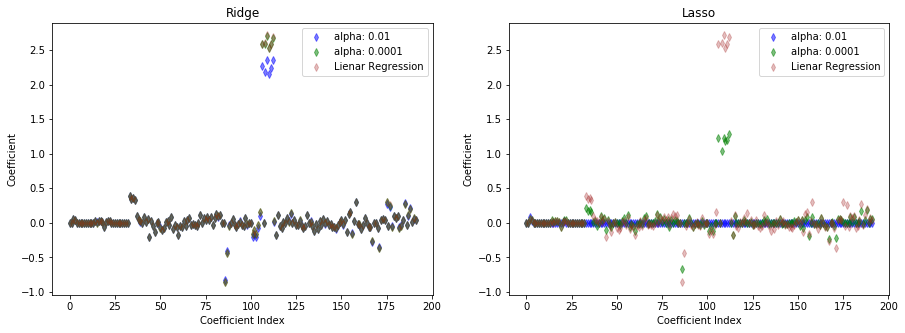

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for c, m in zip(color, model_ridge):
    m.fit(X_train, y_train)
    plt.plot(np.arange(X_train.shape[1]), m.coef_.reshape(-1), linestyle = 'none', marker = 'd', markersize = 5,alpha=0.5, color = c, label = 'alpha: {}'.format(m.alpha))

plt.plot(np.arange(X_train.shape[1]), lm.coef_.reshape(-1), linestyle = 'none', marker = 'd', markersize = 5,alpha=0.3, color = 'brown', label = 'Lienar Regression')
plt.title('Ridge')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient')
plt.legend()
    
plt.subplot(1,2,2)
for c, m in zip(color, model_lasso):
    m.fit(X_train, y_train)
    plt.plot(np.arange(X_train.shape[1]), m.coef_.reshape(-1), linestyle = 'none', marker = 'd', markersize = 5,alpha=0.5, color = c, label = 'alpha: {}'.format(m.alpha))
plt.plot(np.arange(X_train.shape[1]), lm.coef_.reshape(-1), linestyle = 'none', marker = 'd', markersize = 5,alpha=0.3, color = 'brown', label = 'Lienar Regression')
plt.title('Lasso')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient')
plt.legend()

plt.show()

The coefficients of the Ridge model are close to zero, but most do not go to exactly zero. However, we can see that the coefficients of the Lasso model are mostly 0.

### 3.4. ElasticNet

ElasticNet is a combination of ridge and lasso's L2 and L1 norm.

$\hat{\beta_{EN}} = \underset{\beta}{\arg\min}\{ \frac{1}{2}(Y-X\beta)^{T}(Y-X\beta) + \lambda(\alpha \|\beta\|_{1} + \frac{1-\alpha}{2}\|\beta\|^{2}) \}$

In python, we can use it by ElasticNet from sklearn.linear_model.

In [15]:
en = ElasticNet()
params = {'alpha': list(np.linspace(0.01,0.1,20)), 'l1_ratio':[.2,.4,.6,.8]}

In [16]:
clf_EN = GridSearchCV(en, params, cv = 5, scoring = 'neg_mean_squared_error')
clf_EN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.01473684210526316,
                                   0.019473684210526317, 0.02421...
                                   0.04789473684210527, 0.052631578947368425,
                                   0.05736842105263158, 0.06210526315789474,
                                   0.0668421052631579, 0.07157894736842106,
                                   0.07631578947368421, 0.08105263157894736,
                                   0.08578947368421053, 0.09052631578947369,
                               

In [17]:
clf_EN.best_params_

{'alpha': 0.01, 'l1_ratio': 0.2}

When alpha = 0.01, l1_ratio = 0.2, we can have smallest mse among assigned params values.

In [18]:
y_hat_en = clf_EN.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_en))

print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.138953851623122
